# Text Classification with indonesian BERT

The following codes have been copied from https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/08.sentiment-analysis-with-bert.ipynb

In [1]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.7.7
IPython 7.13.0

numpy 1.18.4
pandas 1.0.5
torch 1.4.0
transformers 2.11.0


In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# The dataset can be downloaded from https://github.com/cahya-wirawan/language-modeling/tree/master/data
# and put it under the directory "/dataset/panl"

In [4]:
data = "/dataset/panl"

In [5]:
df_train = pd.read_csv(f'{data}/bppt_panl_train.csv', names=["label","text"])
df_test = pd.read_csv(f'{data}/bppt_panl_test.csv', names=["label","text"])
class_names = ['Economy', 'International', 'Science', 'Sport']

In [6]:
df_train.head()

,label,text
0,1,"Saya berada di sini dua tahun lalu, tapi saat ..."
1,0,Pertumbuhan ekonomi 2007 yang diproyeksikan me...
2,3,Pelatih Real Bernd Schuster harus mengeluarkan...
3,2,Laporan itu adalah pengumuman kedua dari badan...
4,0,"Lonjakan laba bersih tersebut, selain didorong..."


In [7]:
df_test.head()

,label,text
0,1,Kedua orang yang cedera itu berada dalam kondi...
1,0,"Paradoksnya di sisi lain, sinyal akan diakuiny..."
2,0,"Menurut dia, harga minyak mentah dunia saat in..."
3,2,Pengkajian ini memberikan konfirmasi bahwa kit...
4,3,Gol akhir Marco Borriello membuat Genoa mendap...


In [8]:
df_test.loc[10].text

'Proses degradasi material organik ini tanpa melibatkan oksigen disebut anaerobik digestion Gas yang dihasilkan sebagian besar berupa metana.'

In [9]:
df_train.shape, df_test.shape

((21620, 2), (2403, 2))

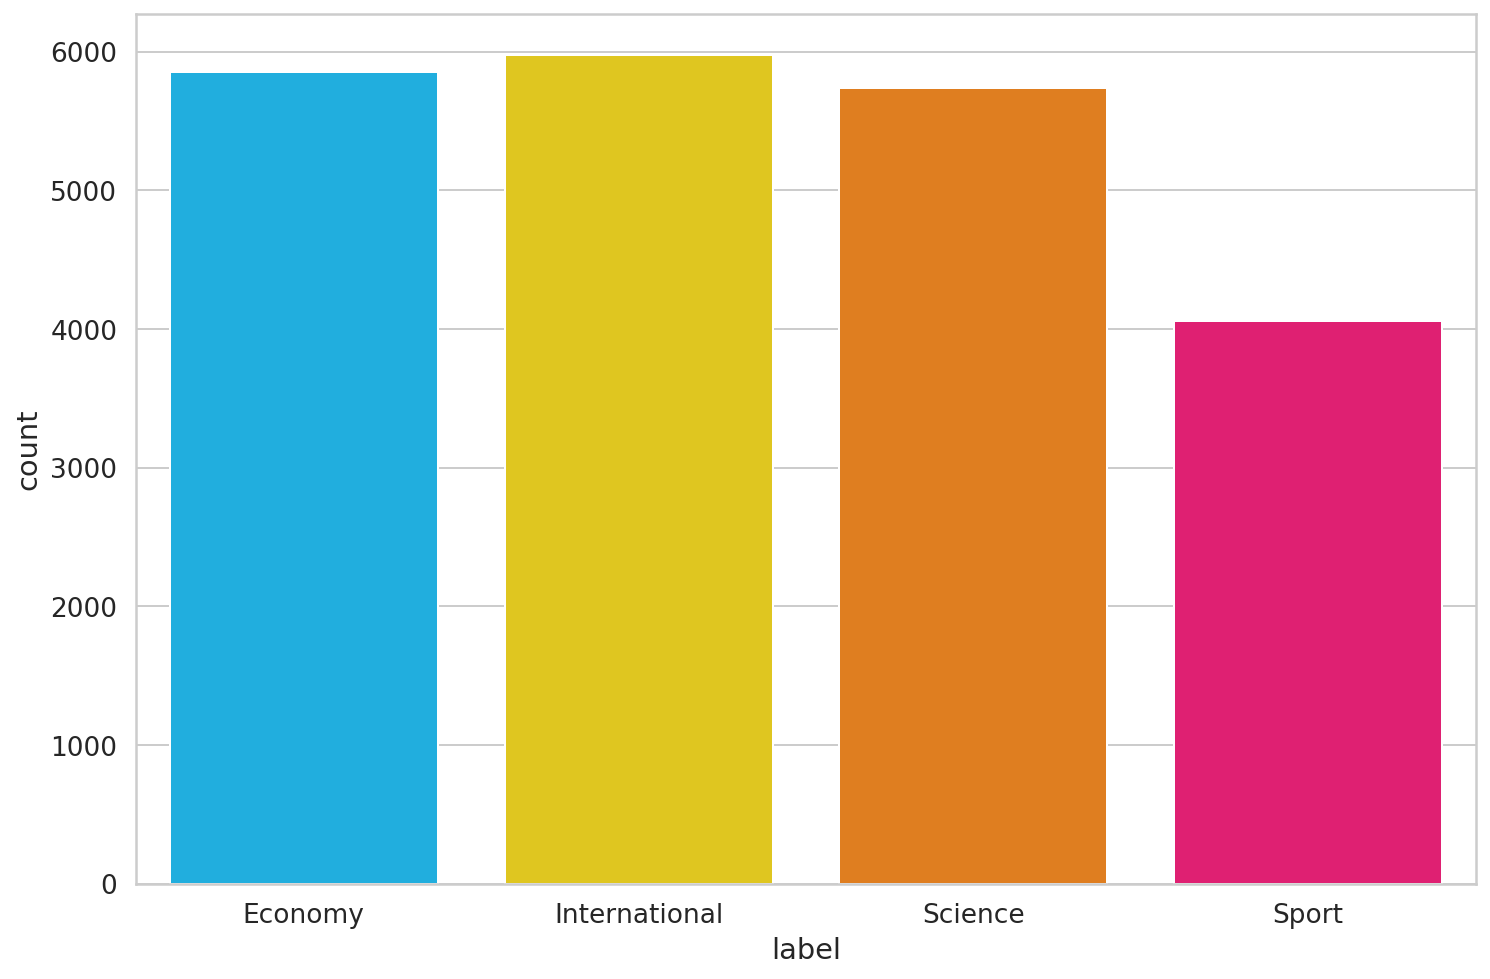

In [11]:
ax = sns.countplot(df_train.label)
plt.xlabel('label');
ax.set_xticklabels(class_names);

## Data Preprocessing

In [12]:
PRE_TRAINED_MODEL_NAME = 'cahya/bert-base-indonesian-522M'

In [13]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [14]:
sample_txt = 'Proses degradasi material organik ini tanpa melibatkan oksigen disebut anaerobik digestion Gas.'

In [15]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Proses degradasi material organik ini tanpa melibatkan oksigen disebut anaerobik digestion Gas.
   Tokens: ['proses', 'degradasi', 'material', 'organik', 'ini', 'tanpa', 'melibatkan', 'oksigen', 'disebut', 'anaer', '##obik', 'dig', '##esti', '##on', 'gas', '.']
Token IDs: [2530, 15629, 7177, 7426, 1542, 2756, 5252, 4284, 2062, 28906, 20921, 2673, 7459, 1513, 4041, 17]


## Special Tokens

In [16]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 1)

In [17]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 3)

In [18]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 0)

In [19]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 2)

In [20]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [21]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([    3,  2530, 15629,  7177,  7426,  1542,  2756,  5252,  4284,  2062,
        28906, 20921,  2673,  7459,  1513,  4041,    17,     1,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2])

In [22]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [23]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'proses',
 'degradasi',
 'material',
 'organik',
 'ini',
 'tanpa',
 'melibatkan',
 'oksigen',
 'disebut',
 'anaer',
 '##obik',
 'dig',
 '##esti',
 '##on',
 'gas',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

## Choosing Sequence Length

In [24]:
token_lens = []

for txt in df_train.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

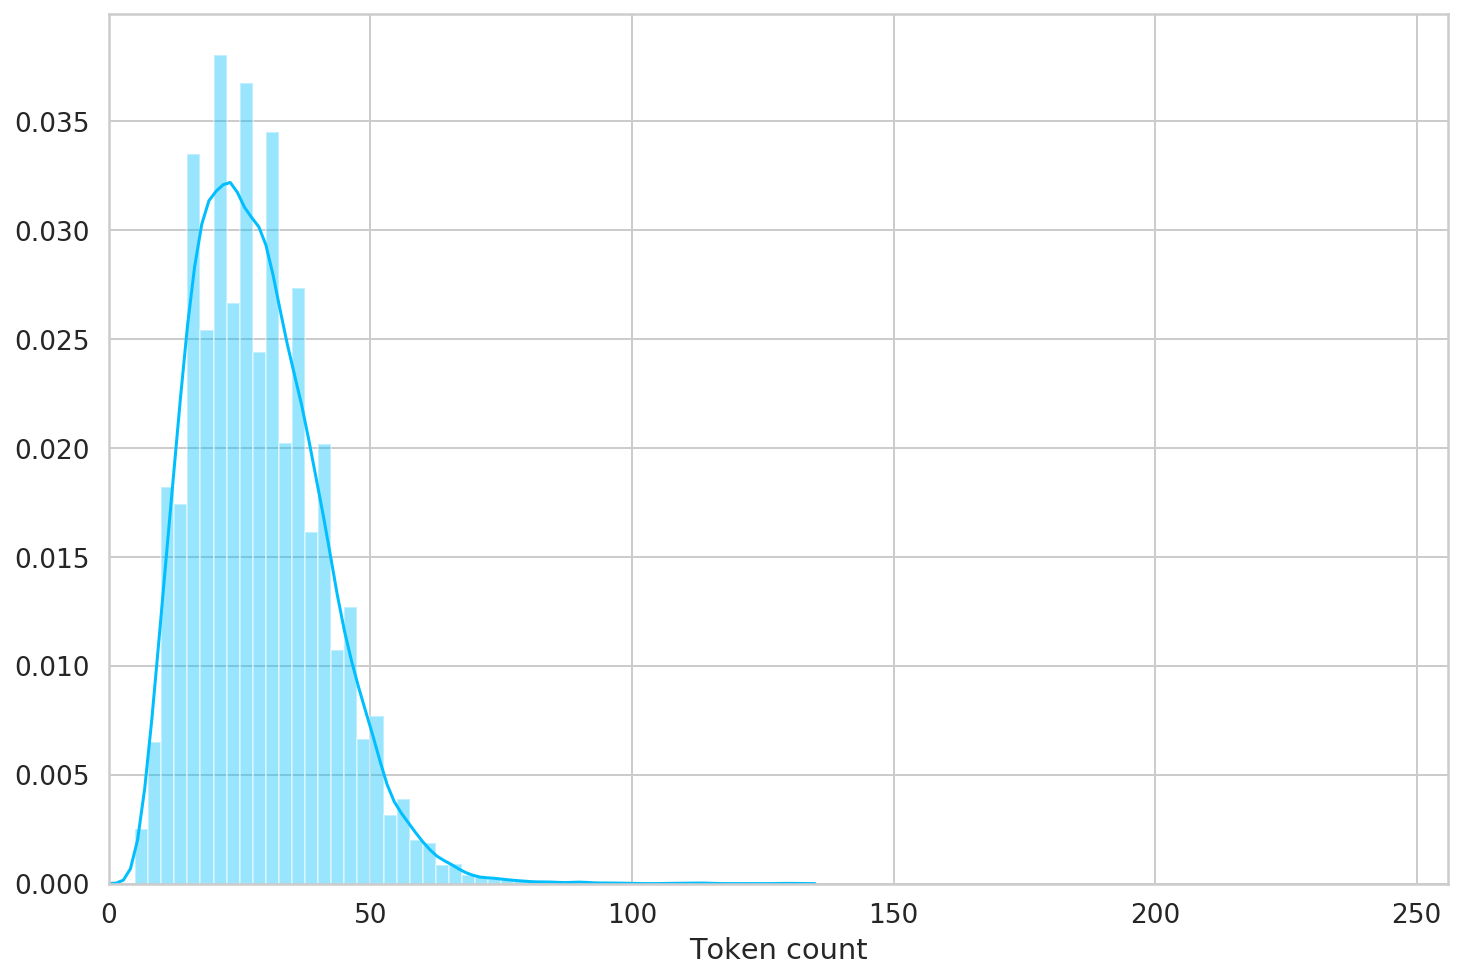

In [25]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [26]:
MAX_LEN = 150

In [27]:
class PanlDataset(Dataset):

  def __init__(self, texts, labels, tokenizer, max_len):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    text = str(self.texts[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

In [28]:
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=RANDOM_SEED)

In [29]:
df_train.shape, df_val.shape, df_test.shape

((19458, 2), (2162, 2), (2403, 2))

In [30]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = PanlDataset(
    texts=df.text.to_numpy(),
    labels=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [31]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [32]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])

In [33]:
data

{'text': ['Konferensi dua hari itu, yang diselenggarakan oleh Kementerian Luar Negeri Perancis dan Badan Anak-anak PBB (UNICEF), akan mengkaji cara-cara untuk menghentikan perekrutan prajurit di bawah umur, yang jumlahnya diperkirakan 250.000 orang di berbagai penjuru dunia.',
  'Saya kira kami lebih tabah, kata Nash pada wartawan usai Suns mengatasi defisit 18-poin.',
  'Saya kira, bulan Maret bulan yang paling tenang dari sisi inflasi dan sebagainya, katanya.',
  'Menteri Negara Perencanaan dan Pembangunan Nasional/Kepala Bappenas Paskah Suzetta mengatakan pihaknya akan membatalkan pembiayaan proyek pembangunan sekitar 6-7 miliar dolar AS dari 15 miliar yang sudah disepakati sejak tahun 2000, karena dianggap under performance tidak baik.',
  'Unsur ini ditemukan di bintang-bintang dan memainkan peranan yang penting dalam memberikan sumber energi jagat raya melalui reaksi proton-proton dan siklus karbon nitrogen.',
  'Ketika Saddam pada satu saat diperkenankan berjalan-jalan sejenak d

In [34]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


## Text Classification with BERT and Hugging Face

In [35]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [36]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [37]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [38]:
bert_model.config.hidden_size

768

In [39]:
pooled_output.shape

torch.Size([1, 768])

In [40]:
class TextClassifier(nn.Module):

  def __init__(self, n_classes, dropout=0.3):
    super(TextClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=dropout)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [41]:
model = TextClassifier(len(class_names), 0.5)
model = model.to(device)

In [42]:
model

TextClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [43]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 150])
torch.Size([16, 150])


In [44]:
input_ids

tensor([[    3,  5885,  1887,  ...,     2,     2,     2],
        [    3,  3245,  4826,  ...,     2,     2,     2],
        [    3,  3245,  4826,  ...,     2,     2,     2],
        ...,
        [    3, 18584,  1006,  ...,     2,     2,     2],
        [    3,  4649,    16,  ...,     2,     2,     2],
        [    3, 29887,  1708,  ...,     2,     2,     2]], device='cuda:0')

In [45]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2220, 0.2872, 0.1815, 0.3093],
        [0.1940, 0.2268, 0.4283, 0.1509],
        [0.2214, 0.2680, 0.2248, 0.2857],
        [0.2285, 0.4241, 0.1883, 0.1591],
        [0.1683, 0.2920, 0.3283, 0.2115],
        [0.2939, 0.2450, 0.2572, 0.2038],
        [0.2887, 0.2879, 0.2220, 0.2014],
        [0.2258, 0.3029, 0.2229, 0.2484],
        [0.2916, 0.2000, 0.3112, 0.1972],
        [0.2405, 0.1394, 0.4295, 0.1906],
        [0.3426, 0.1457, 0.3154, 0.1964],
        [0.2189, 0.1668, 0.2880, 0.3264],
        [0.1589, 0.2829, 0.3182, 0.2400],
        [0.1992, 0.2283, 0.2395, 0.3330],
        [0.1865, 0.1790, 0.2879, 0.3467],
        [0.2301, 0.2020, 0.2965, 0.2714]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [46]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [47]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["labels"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [48]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [49]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.3569647971917198 accuracy 0.8916127042861548
Val   loss 0.27332526927485185 accuracy 0.9222941720629048

Epoch 2/10
----------
Train loss 0.1838173731830929 accuracy 0.9530270325829994
Val   loss 0.31905745808035135 accuracy 0.9292321924144311

Epoch 3/10
----------
Train loss 0.12451233090059916 accuracy 0.9720937403638606
Val   loss 0.32548166186932254 accuracy 0.9329324699352451

Epoch 4/10
----------
Train loss 0.09747215699566714 accuracy 0.9791345462020763
Val   loss 0.3737323562450269 accuracy 0.933395004625347

Epoch 5/10
----------
Train loss 0.06952814632627252 accuracy 0.9861753520402919
Val   loss 0.4315516423872289 accuracy 0.9301572617946346

Epoch 6/10
----------
Train loss 0.047711263558442414 accuracy 0.9900298077911399
Val   loss 0.48455239920055165 accuracy 0.9329324699352451

Epoch 7/10
----------
Train loss 0.0359444150375164 accuracy 0.9923938739849933
Val   loss 0.507469551089932 accuracy 0.933395004625347

Epoch 8/10
----------

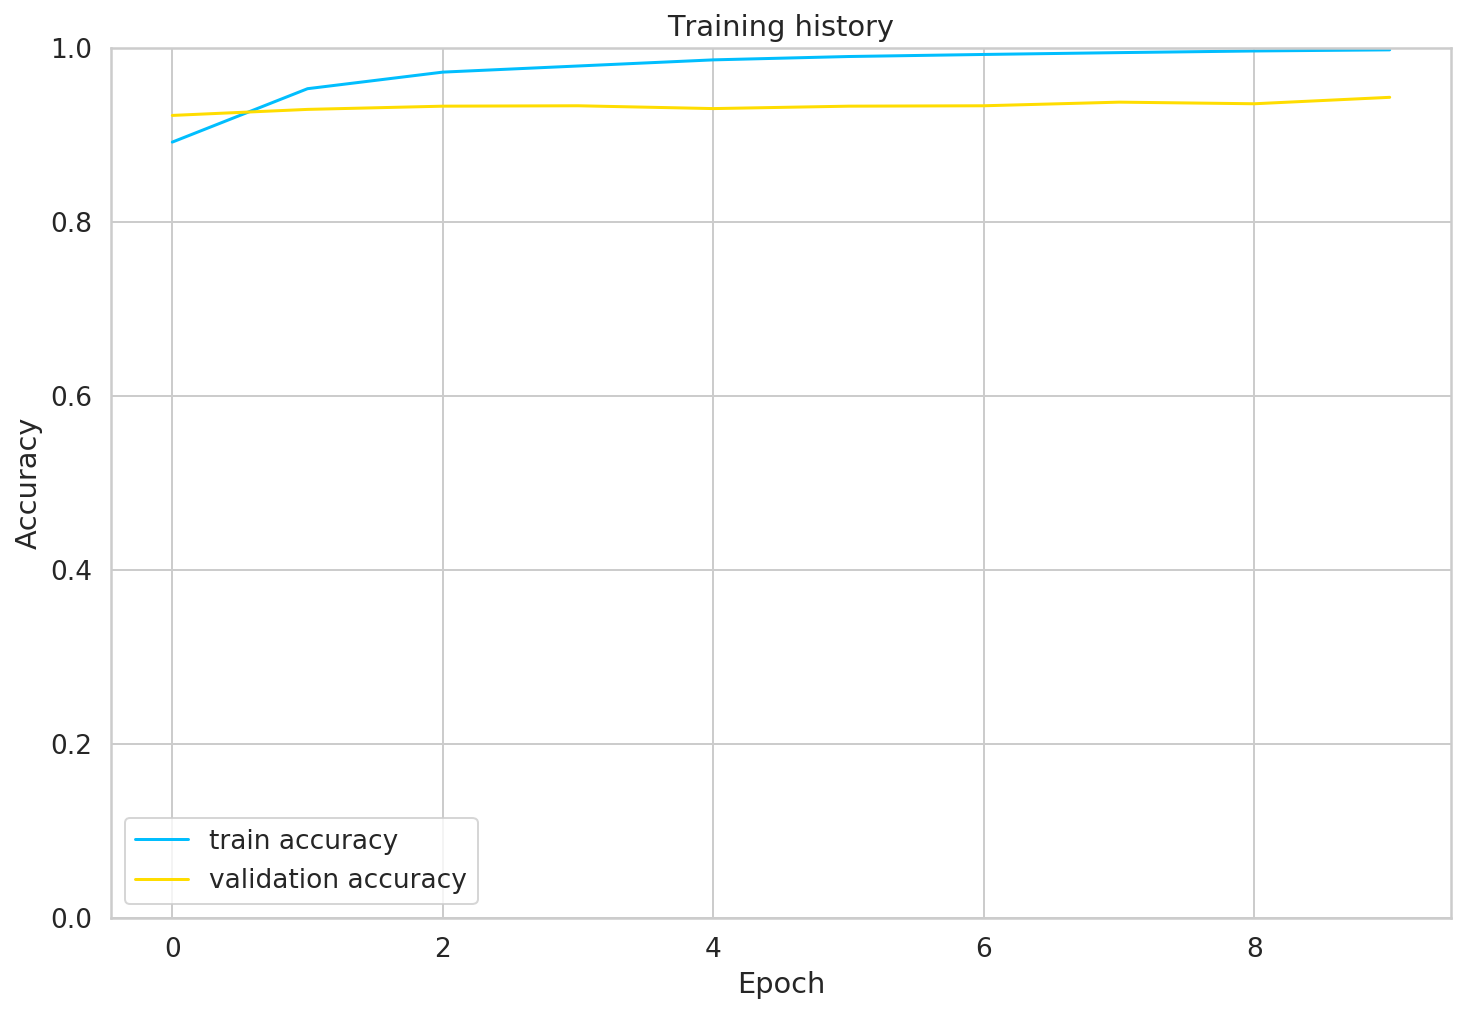

In [50]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluation

In [51]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9429879317519767

In [52]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            texts.extend(text)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, prediction_probs, real_values

In [53]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [54]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

      Economy       0.95      0.96      0.96       690
International       0.96      0.92      0.94       668
      Science       0.91      0.94      0.92       617
        Sport       0.95      0.96      0.96       428

     accuracy                           0.94      2403
    macro avg       0.94      0.94      0.94      2403
 weighted avg       0.94      0.94      0.94      2403



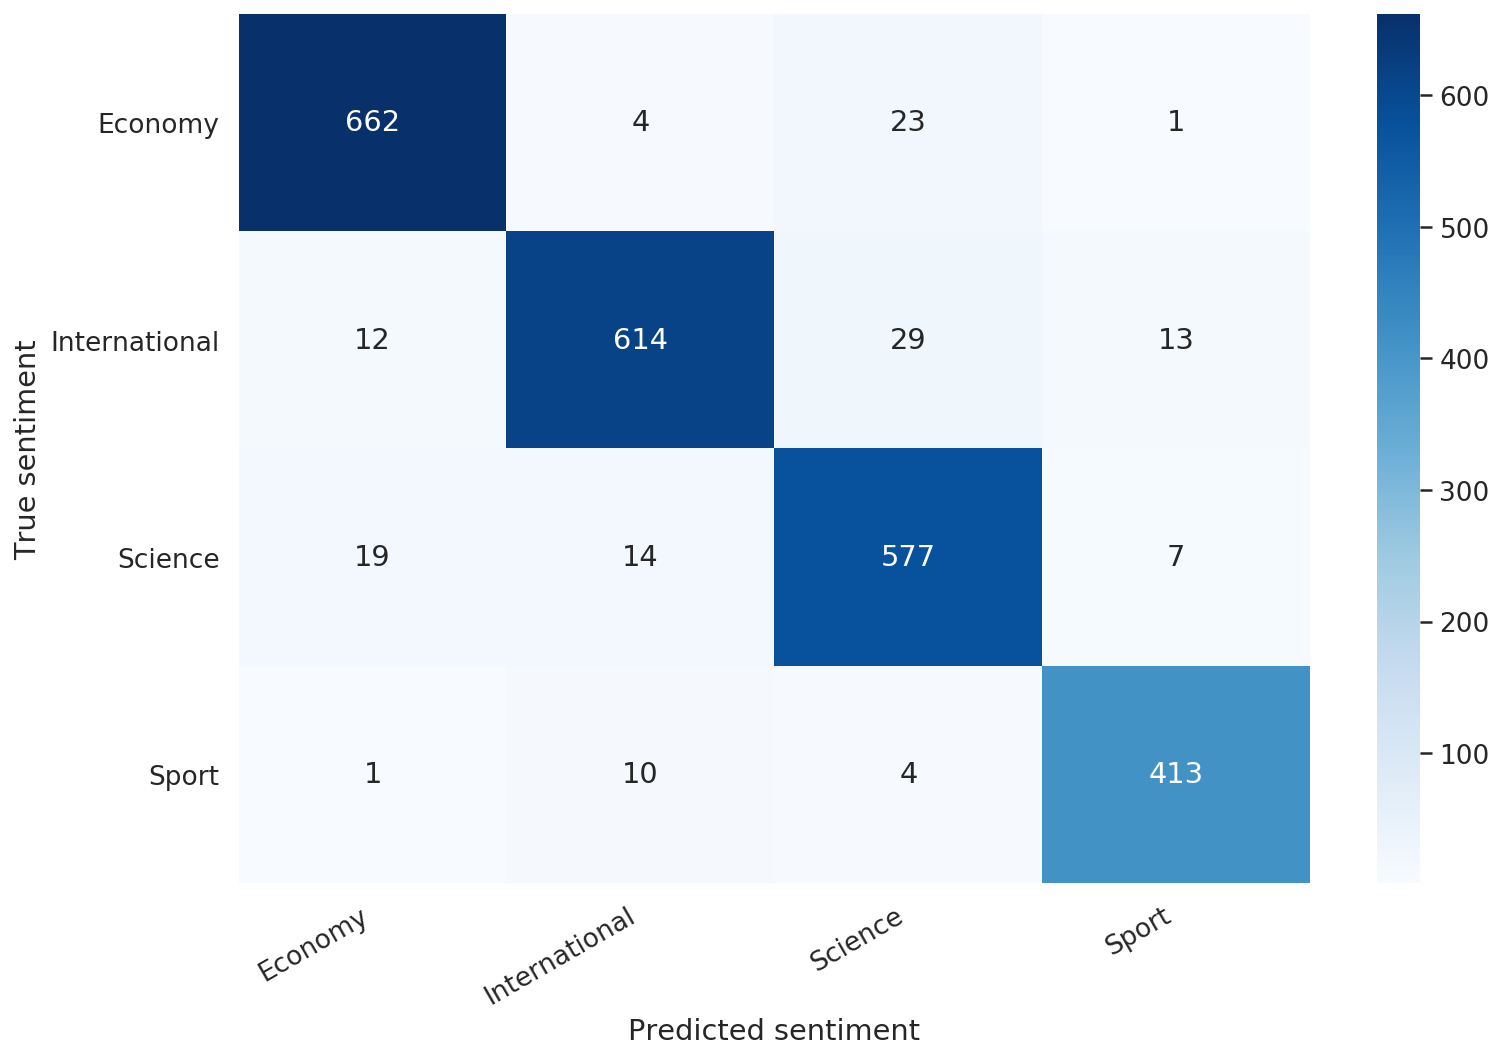

In [55]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [56]:
idx = 50

text = y_texts[idx]
true_label = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [57]:
print("\n".join(wrap(text)))
print()
print(f'True label: {class_names[true_label]}')

Jumlah hutang luar negeri pemerintah terus bertambah hingga tahun 1995
mencapai US$ 59,588 milyar.

True label: Economy


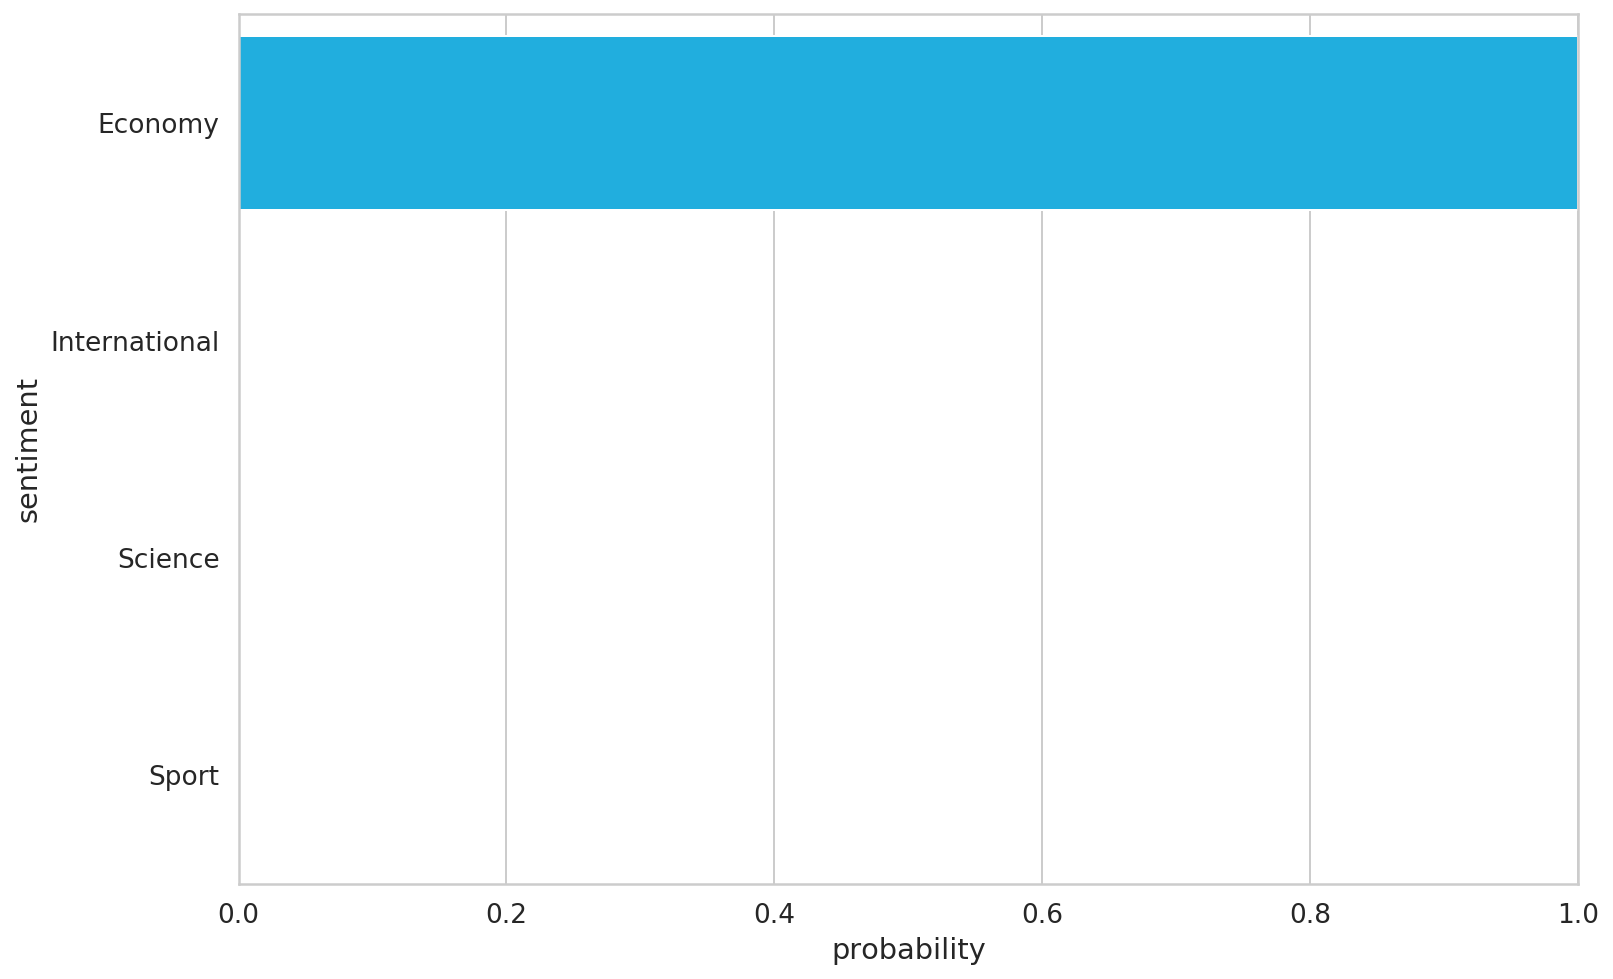

In [58]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

## Predicting on Raw Text

In [59]:
text = "Indonesia akan bertanding dalam cabang bulutangkis di Olimpiade ke 30 di Yunani."

In [60]:
encoded_text = tokenizer.encode_plus(
  text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [61]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Text: {text}')
print(f'Label  : {class_names[prediction]}')

Text: Indonesia akan bertanding dalam cabang bulutangkis di Olimpiade ke 30 di Yunani.
Label  : Sport


## Summary